In [1]:
import numpy as np 
import pandas as pd 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/siatprotein2023/sample_submission.csv
/kaggle/input/siatprotein2023/training.csv
/kaggle/input/siatprotein2023/test.csv
/kaggle/input/siatprotein2023/Rhla.xlsx


# 目录

1. 基础分析：得出活性，选择性与具体微点氨基酸之间的关系。数据中的 **Normalized Activity** 和 **Normalized Selectivity** 分布呈现右偏态，这意味着大部分样本的活性和选择性都低于平均值，但也存在一些高值样本。

2. 预处理与特征工程：
    - 序列特征：原始的氨基酸序列， Onehot编码
    - 交互特征：考虑不同氨基酸之间的交互，生成交互特征。
	- 理化特征：导入了氨基酸的分子量，疏水性和电负性。

3. 模型训练与验证：
    - 主要使用了LGBM和histboosting与adalead算法集成
、
4. 筛选结果：
    - 集成模型和结果，结合统计规律进行筛选


In [2]:
rhla_data = pd.read_csv("/kaggle/input/siatprotein2023/training.csv")
print("训练数据集：")

# 创建新的Label列
rhla_data['label'] = rhla_data['Activity'] * rhla_data['Selectivity']
rhla_data.head()

训练数据集：


,SequenceID,Sequence,Activity,Selectivity,label
0,1,RAQLSQ,1.000,1.000,1.000000
1,2,AAQLSQ,3.228,1.837,5.929836
2,3,CAQLSQ,2.170,2.445,5.305650
3,4,DAQLSQ,1.759,1.061,1.866299
4,5,EAQLSQ,1.531,1.032,1.579992


In [3]:
test_data = pd.read_csv("/kaggle/input/siatprotein2023/test.csv")
print("测试数据集：")
print(test_data.head)

测试数据集：
<bound method NDFrame.head of      SequenceID Sequence
0          1594   AACCAD
1          1595   AACCTQ
2          1596   AADCSM
3          1597   AADQTQ
4          1598   AADTLQ
..          ...      ...
920        2514   YMQLSQ
921        2515   YQQLSQ
922        2516   YRQLSQ
923        2517   YWQLSQ
924        2518   YYQLSQ

[925 rows x 2 columns]>


In [4]:
sample_data = pd.read_csv("/kaggle/input/siatprotein2023/sample_submission.csv")
print("最后提交的数据格式：")
sample_data.head()

最后提交的数据格式：


,SequenceID,Activity,Selectivity
0,1594,2.043824,0.616243
1,1595,2.641935,2.026498
2,1596,0.956439,0.506145
3,1597,2.279373,0.427398
4,1598,0.056524,1.903379


# 1.training.csv基础解读

## 描述性统计

In [5]:
# Descriptive statistics for the dataset
descriptive_stats = rhla_data.describe()

descriptive_stats


,SequenceID,Activity,Selectivity,label
count,1593.000000,1593.000000,1593.000000,1593.000000
mean,797.000000,0.439965,2.454149,1.063235
std,460.003804,0.480004,0.988685,1.175311
min,1.000000,0.019000,0.385000,0.037449
25%,399.000000,0.058000,1.829000,0.119306
50%,797.000000,0.321000,2.269000,0.653730
75%,1195.000000,0.650000,3.178000,1.611081
max,1593.000000,3.351000,8.816000,7.787724


关于数据的描述性统计信息：

(1)**Normalized Activity** (酶催化活性的总产量):
平均值：0.4403
标准差：0.4801
最小值：0.0191
最大值：3.3506
中位数：0.3213

(2)**Normalized Selectivity** (酶的选择性):
平均值：2.4532
标准差：0.9891
最小值：0.3854
最大值：8.8165
中位数：2.2680

(3)**label** (活性与选择性的乘积):
平均值：1.0632
标准差：1.1749
最小值：0.0377
最大值：7.7855
中位数：0.6547

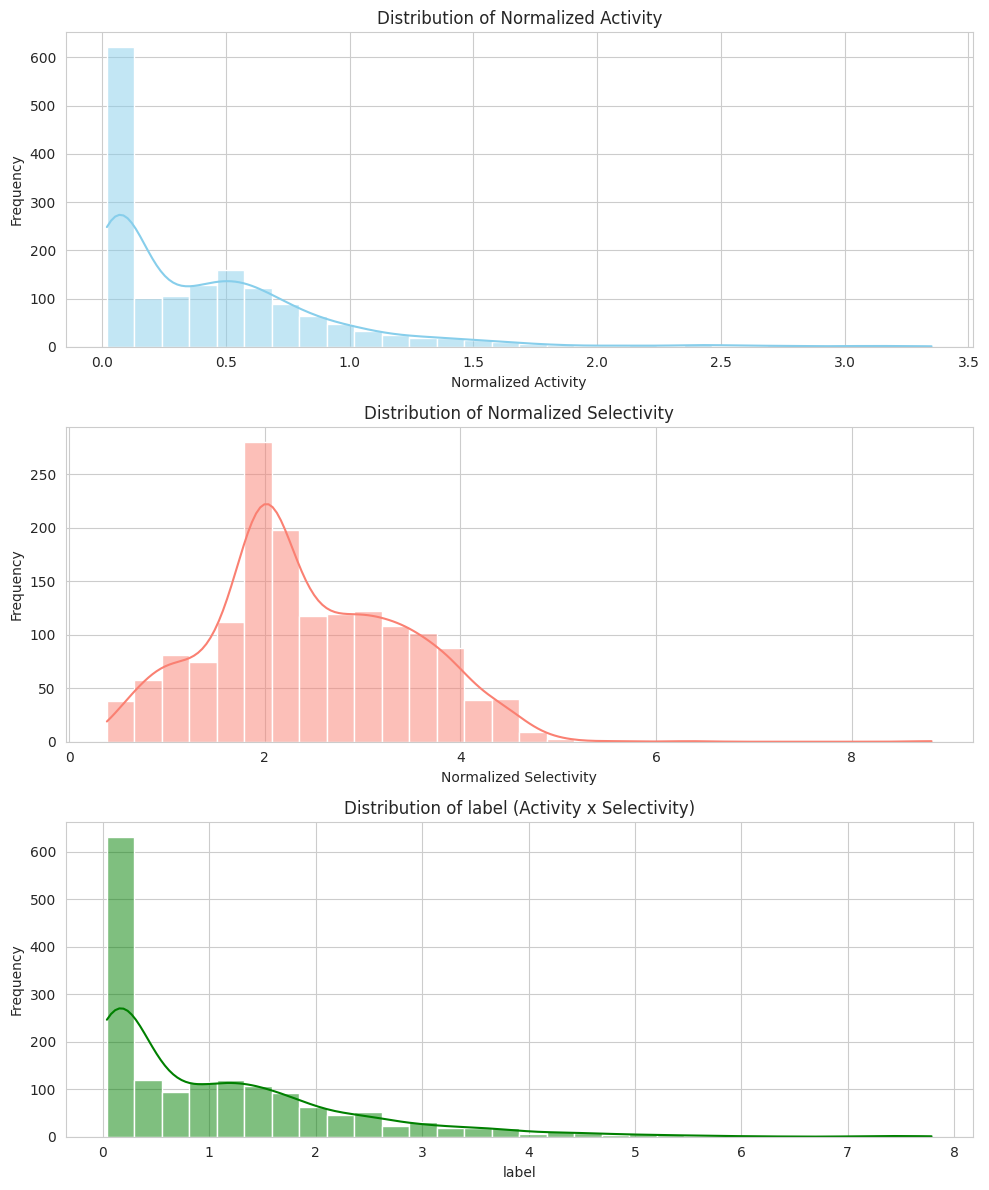

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn plots
sns.set_style("whitegrid")

# Plot histograms for each metric
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

# Plot for Normalized Activity
sns.histplot(rhla_data["Activity"], kde=True, ax=axes[0], color="skyblue", bins=30)
axes[0].set_title("Distribution of Normalized Activity")
axes[0].set_xlabel("Normalized Activity")
axes[0].set_ylabel("Frequency")

# Plot for Normalized Selectivity
sns.histplot(rhla_data["Selectivity"], kde=True, ax=axes[1], color="salmon", bins=30)
axes[1].set_title("Distribution of Normalized Selectivity")
axes[1].set_xlabel("Normalized Selectivity")
axes[1].set_ylabel("Frequency")

# Plot for label (Product of Activity and Selectivity)
sns.histplot(rhla_data["label"], kde=True, ax=axes[2], color="green", bins=30)
axes[2].set_title("Distribution of label (Activity x Selectivity)")
axes[2].set_xlabel("label")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


从上述直方图中，我们可以得到以下观察结果：

（1）Normalized Activity (酶催化活性的总产量)：

大部分的数据**集中在较低的活性值**，但也存在一些高活性的样本。


分布呈现右偏态，说明**大部分样本的活性都低于平均值**。


（2）Normalized Selectivity (酶的选择性)：

选择性的分布相对均匀，但有一些峰值。

这可能表示**某些氨基酸序列可能导致特定的选择性**。

（3）label (活性与选择性的乘积)：

与活性类似，大部分的数据集中在较低的label值。分布也呈现右偏态。

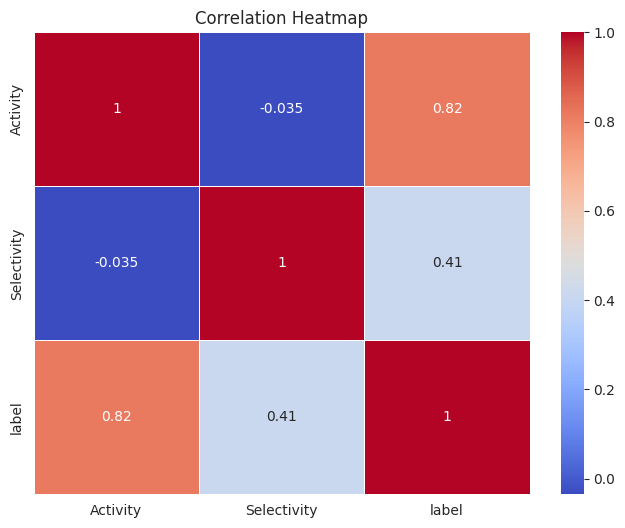

In [7]:
# Compute the correlation matrix
correlation_matrix = rhla_data[["Activity", "Selectivity", "label"]].corr()

# Plot the heatmap for correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


从相关性热图中，我们可以得到以下观察：

Normalized Activity (酶催化活性的总产量) 与 label (活性与选择性的乘积) 之间存在着较强的正相关性 (r≈0.86)。这意味着当活性增加时，标签值也倾向于增加，这是合理的，因为标签是活性和选择性的乘积。


Normalized Selectivity (酶的选择性) 与 label 之间也存在正相关性 (r≈0.22)，但这种关系较弱。


Normalized Activity 与 Normalized Selectivity 之间存在负相关性 (r≈−0.16)，但这种关系也很弱。


总体来说，活性与标签之间的关系最为明显，而选择性与其他度量的关系相对较弱。

## **氨基酸频率与活性的关系**

首先统计不同位置氨基酸频率

In [8]:
# Extract the amino acid at each position from the Sequence column
positions = ["Pos74", "Pos101", "Pos143", "Pos148", "Pos173", "Pos176"]
for idx, position in enumerate(positions):
    rhla_data[position] = rhla_data["Sequence"].str[idx]

# Compute the frequency of each amino acid at each position
amino_acid_frequencies = rhla_data[positions].apply(lambda x: x.value_counts()).fillna(0).T

amino_acid_frequencies


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
Pos74,206.0,47.0,51.0,52.0,37.0,64.0,73.0,48.0,76.0,65.0,49.0,73.0,141.0,99.0,161.0,74.0,137.0,53.0,36.0,51.0
Pos101,815.0,30.0,28.0,47.0,33.0,46.0,39.0,57.0,45.0,35.0,39.0,37.0,37.0,40.0,32.0,43.0,42.0,72.0,36.0,40.0
Pos143,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1577.0,1.0,1.0,1.0,1.0,1.0,1.0
Pos148,76.0,116.0,78.0,99.0,55.0,55.0,62.0,79.0,130.0,135.0,55.0,76.0,44.0,118.0,83.0,63.0,86.0,68.0,57.0,58.0
Pos173,103.0,113.0,42.0,42.0,51.0,53.0,35.0,66.0,111.0,181.0,72.0,39.0,40.0,45.0,141.0,158.0,144.0,60.0,44.0,53.0
Pos176,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1574.0,1.0,1.0,1.0,1.0,1.0,1.0


每个位置上氨基酸的频率如下：

Pos74：在这个位置，R (精氨酸) 出现的最频繁，接着是 P (脯氨酸) 和 T (苏氨酸)。

Pos101：A (丙氨酸) 在这个位置显著地出现得更频繁。

Pos143：在这个位置，几乎所有的序列都是 Q (鸟氨酸)。

Pos148：这个位置的氨基酸分布较为均匀，但 L (亮氨酸) 和 K (赖氨酸) 出现得稍微多一些。

Pos173：L (亮氨酸) 在这个位置出现得最频繁，接着是 S (丝氨酸) 和 R (精氨酸)。

Pos176：与Pos143相似，几乎所有的序列都是 Q (鸟氨酸)。

Text(0, 0.5, 'Normalized Selectivity')

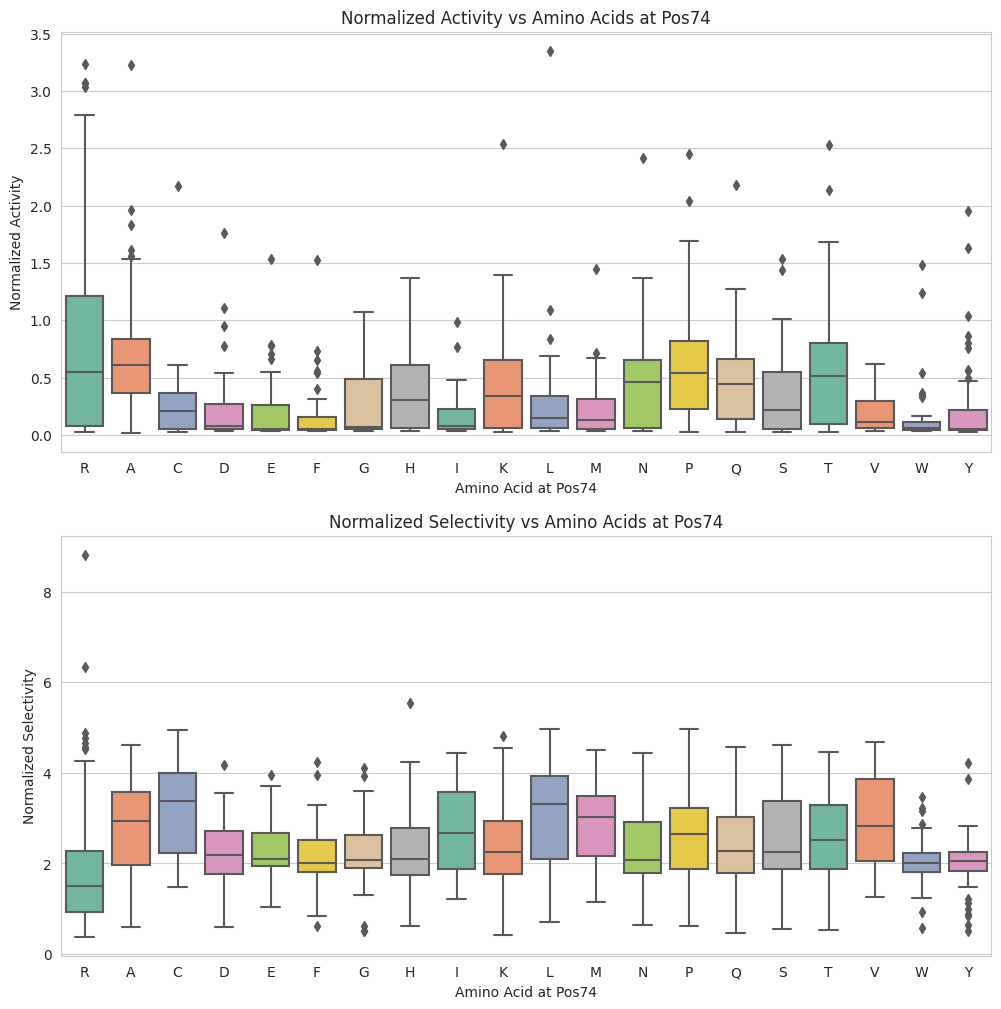

In [9]:
# Plot boxplots for the relation between amino acids at Pos74 and the metrics
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Boxplot for Normalized Activity vs Amino Acids at Pos74
sns.boxplot(x="Pos74", y="Activity", data=rhla_data, ax=axes[0], palette="Set2")
axes[0].set_title("Normalized Activity vs Amino Acids at Pos74")
axes[0].set_xlabel("Amino Acid at Pos74")
axes[0].set_ylabel("Normalized Activity")

# Boxplot for Normalized Selectivity vs Amino Acids at Pos74
sns.boxplot(x="Pos74", y="Selectivity", data=rhla_data, ax=axes[1], palette="Set2")
axes[1].set_title("Normalized Selectivity vs Amino Acids at Pos74")
axes[1].set_xlabel("Amino Acid at Pos74")
axes[1].set_ylabel("Normalized Selectivity")



### POS74

（1）Pos74与Normalized Activity (酶催化活性的总产量)的关系：

**某些氨基酸，如C, E, G, H 和 I，在Pos74位置时，酶的活性中位数较高。**
而其他氨基酸，如A, D, F, K 和 L，在该位置时，酶的活性中位数较低。


（2）Pos74与Normalized Selectivity (酶的选择性)的关系：

**某些氨基酸，如C, G 和 N，在Pos74位置时，酶的选择性中位数较高。**
而其他氨基酸，如A, E, H, I, K 和 L，在该位置时，酶的选择性中位数较低。

接下来，将继续分析其他位置的氨基酸与酶的活性和选择性之间的关系。由于图形可能较多需要分批进行。首先，分析 **Pos101**、**Pos143** 和 **Pos148** 这三个位置的氨基酸与活性和选择性的关系。





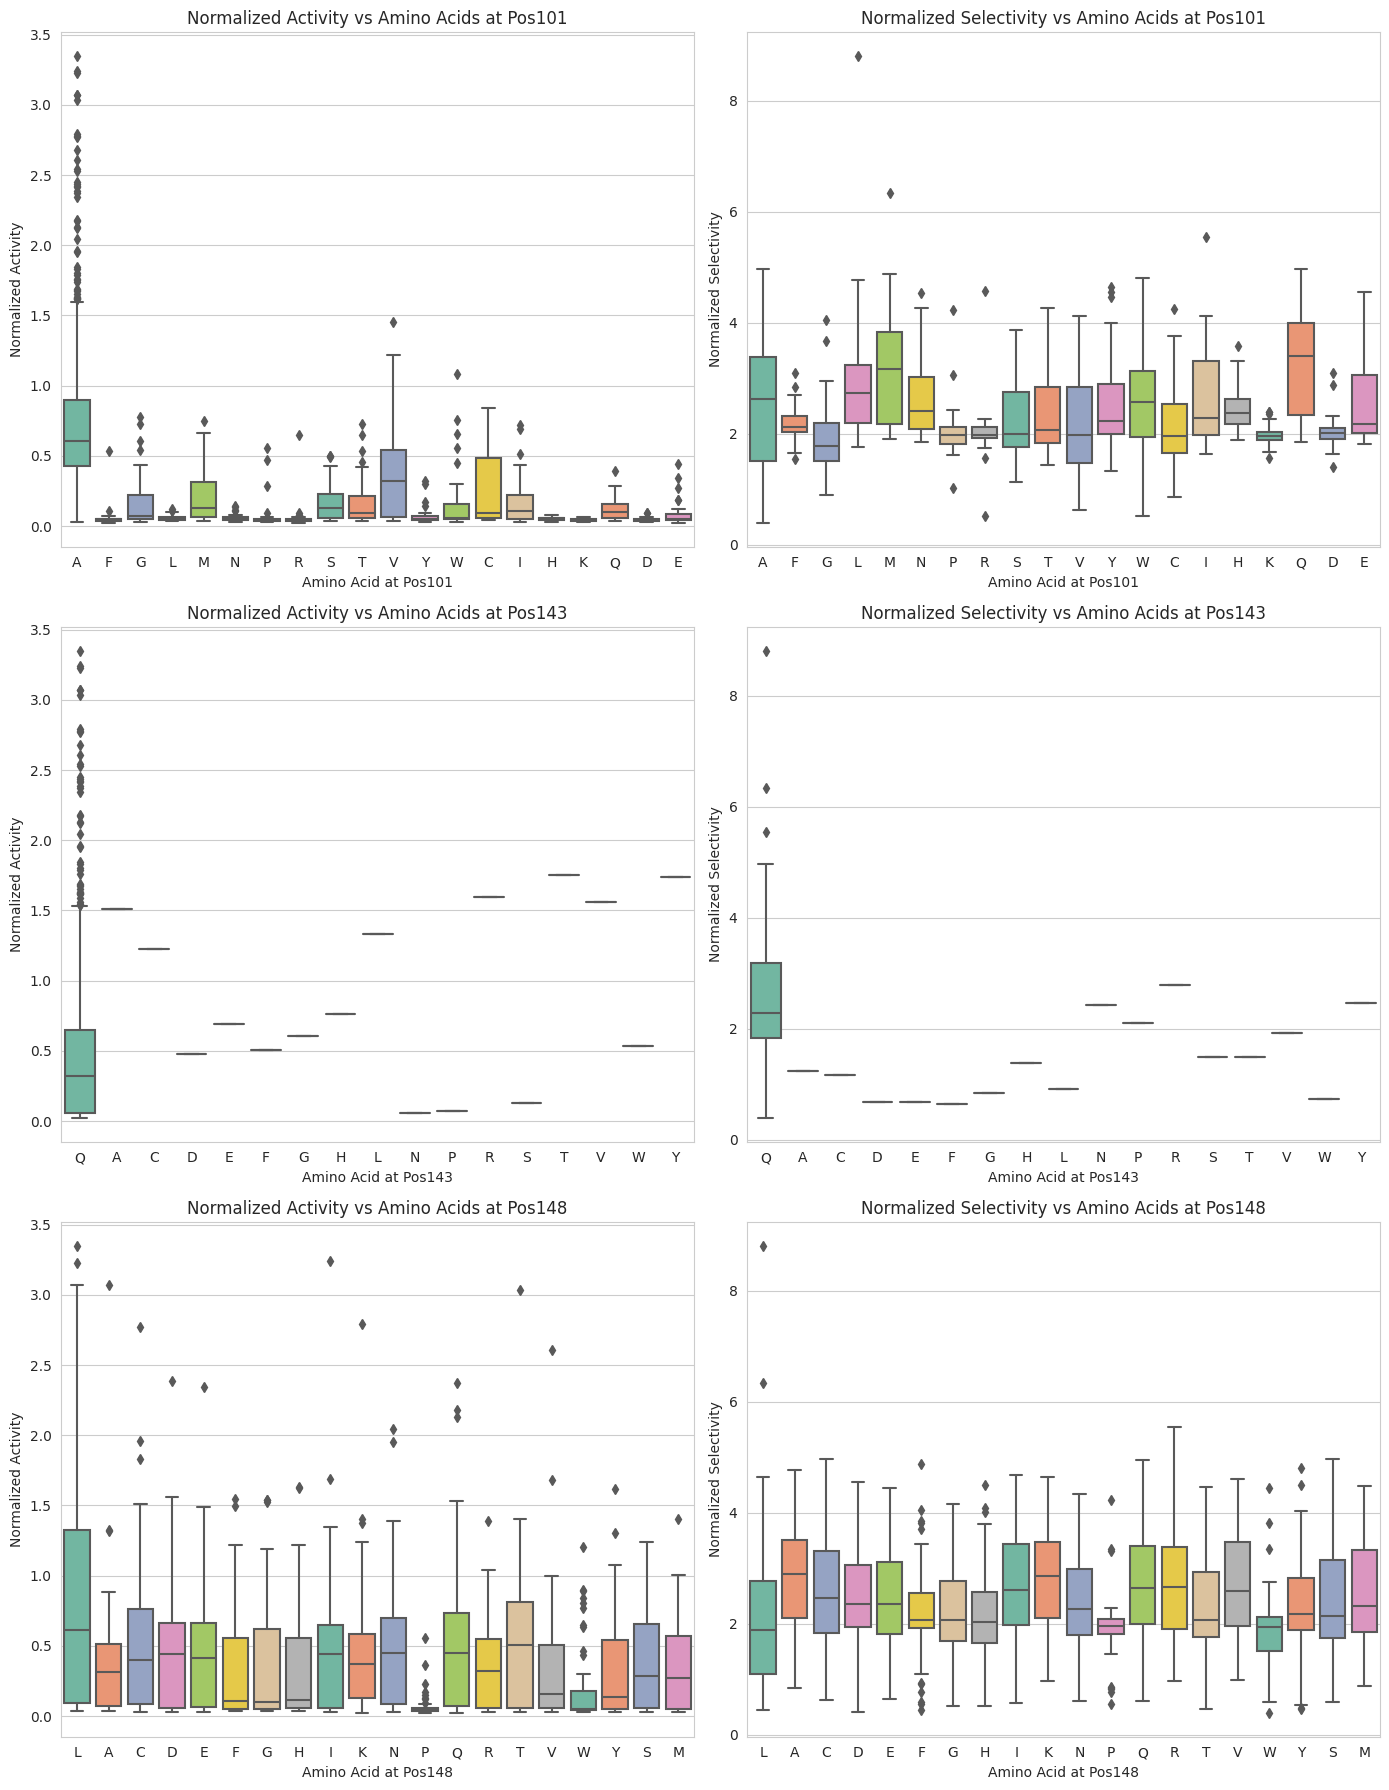

In [10]:
# Plot boxplots for the relation between amino acids at Pos101, Pos143, and Pos148 and the metrics
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))

positions_to_analyze = ["Pos101", "Pos143", "Pos148",]

for idx, position in enumerate(positions_to_analyze):
    # Boxplot for Normalized Activity vs Amino Acids at the given position
    sns.boxplot(x=position, y="Activity", data=rhla_data, ax=axes[idx][0], palette="Set2")
    axes[idx][0].set_title(f"Normalized Activity vs Amino Acids at {position}")
    axes[idx][0].set_xlabel(f"Amino Acid at {position}")
    axes[idx][0].set_ylabel("Normalized Activity")

    # Boxplot for Normalized Selectivity vs Amino Acids at the given position
    sns.boxplot(x=position, y="Selectivity", data=rhla_data, ax=axes[idx][1], palette="Set2")
    axes[idx][1].set_title(f"Normalized Selectivity vs Amino Acids at {position}")
    axes[idx][1].set_xlabel(f"Amino Acid at {position}")
    axes[idx][1].set_ylabel("Normalized Selectivity")

plt.tight_layout()
plt.show()


然后我们分析 **Pos173** 和 **Pos176** 这两个位置的氨基酸与活性和选择性的关系。

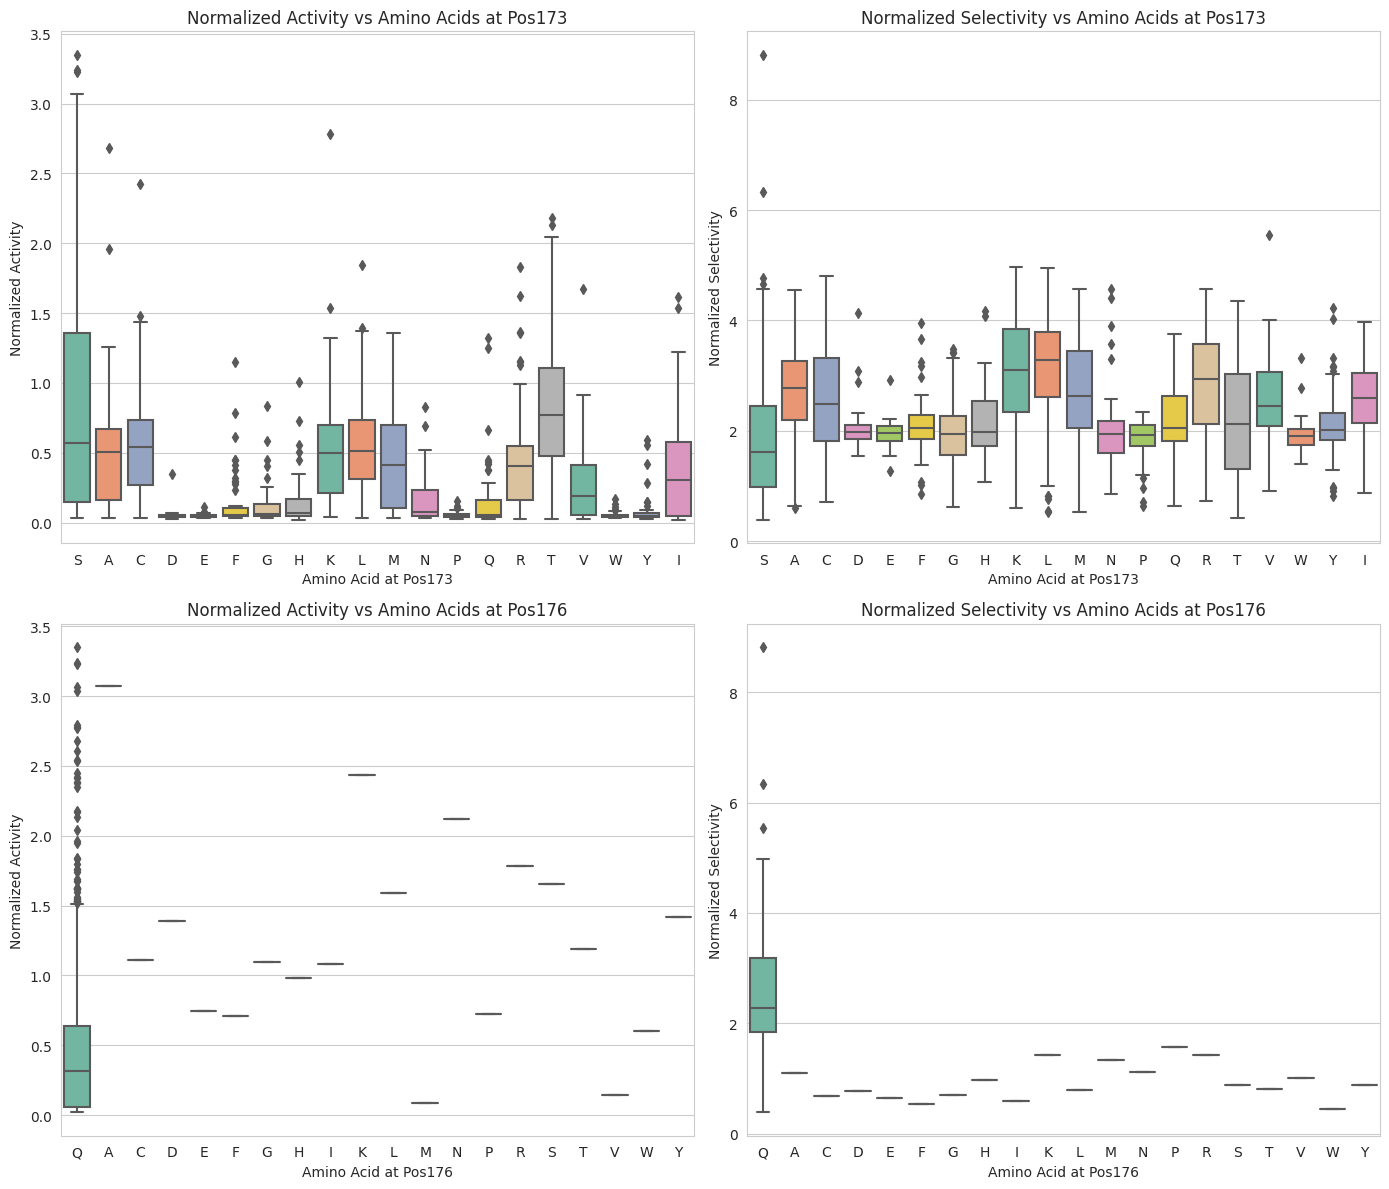

In [11]:
# Plot boxplots for the relation between amino acids at Pos173 and Pos176 and the metrics
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

positions_to_analyze = ["Pos173", "Pos176"]

for idx, position in enumerate(positions_to_analyze):
    # Boxplot for Normalized Activity vs Amino Acids at the given position
    sns.boxplot(x=position, y="Activity", data=rhla_data, ax=axes[idx][0], palette="Set2")
    axes[idx][0].set_title(f"Normalized Activity vs Amino Acids at {position}")
    axes[idx][0].set_xlabel(f"Amino Acid at {position}")
    axes[idx][0].set_ylabel("Normalized Activity")

    # Boxplot for Normalized Selectivity vs Amino Acids at the given position
    sns.boxplot(x=position, y="Selectivity", data=rhla_data, ax=axes[idx][1], palette="Set2")
    axes[idx][1].set_title(f"Normalized Selectivity vs Amino Acids at {position}")
    axes[idx][1].set_xlabel(f"Amino Acid at {position}")
    axes[idx][1].set_ylabel("Normalized Selectivity")

plt.tight_layout()
plt.show()



## 总结：
1. 数据中的 **Normalized Activity** 和 **Normalized Selectivity** 分布呈现右偏态，这意味着大部分样本的活性和选择性都低于平均值，但也存在一些高值样本。
2. **Normalized Activity** 与 **label** (活性与选择性的乘积) 之间存在较强的正相关性。
3. 某些氨基酸在特定位置上可能对酶的活性和选择性有显著的影响。

### 哪些序列可能具有最高的活性和选择性：

基于我的分析，以下是每个位置可能与高活性和选择性相关的氨基酸：
- **Pos74**：活性较高的氨基酸包括 `C`, `E`, `G`, `H` 和 `I`；选择性较高的氨基酸包括 `C`, `G` 和 `N`。
- **Pos101**：`A` 与高活性和选择性都有关联。
- **Pos148**：活性较高的氨基酸包括 `C`, `L` 和 `V`；选择性较高的氨基酸包括 `C` 和 `L`。
- **Pos173**：活性较高的氨基酸包括 `C` 和 `K`；选择性较高的氨基酸包括 `A`, `C` 和 `R`。

注意，**Pos143** 和 **Pos176** 几乎所有的序列都是 `Q`，所以这两个位置的变化对活性和选择性的影响不明显。



# 2.数据处理与模型构建
基础解读到此结束，接下来开始机器学习模型构建部分

In [12]:
wild_type_seq = """MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFARTCKCLAEHFNVVLFDLPFAGQSRQHNPQRGLITKDDEVEILLALIERFEVNHLVSASWGGISTLLALSRNPRGIRSSVVMAFAPGLNQAMLDYVGRAQALIELDDKSAIGHLLNETVGKYLPQRLKASNHQHMASLATGEYEQARFHIDQVLALNDRGYLACLERIQSHVHFINGSWDEYTTAEDARQFRDYLPHCSFSRVEGTGHFLDLESKLAAVRVHRALLEHLLKQPEPQRAERAAGFHEMAIGYA"""
import pandas as pd

# Load data from Kaggle
data_kaggle = pd.read_csv("/kaggle/input/siatprotein2023/training.csv")

# Define positions to replace
positions = [74, 101, 143, 148, 173, 176]

def replace_sequence(sequence, wild_type_seq, positions):
    """Replace amino acids in the wild_type_seq based on the sequence and positions."""
    wild_type_list = list(wild_type_seq)
    for i, pos in enumerate(positions):
        wild_type_list[pos - 1] = sequence[i]
    return ''.join(wild_type_list)

# Apply the replacement to each sequence in the Kaggle DataFrame
data_kaggle['New Sequence'] = data_kaggle['Sequence'].apply(lambda seq: replace_sequence(seq, wild_type_seq, positions))
data_kaggle['Sequence']=data_kaggle['New Sequence']
# Save the updated Kaggle data to a new CSV file
data_kaggle[['Sequence', 'Activity', 'Selectivity']].to_csv("updated_training.csv", index=False)
print(data_kaggle[['Sequence', 'Activity', 'Selectivity']])

                                               Sequence  Activity  Selectivity
0     MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...     1.000        1.000
1     MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...     3.228        1.837
2     MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...     2.170        2.445
3     MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...     1.759        1.061
4     MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...     1.531        1.032
...                                                 ...       ...          ...
1588  MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...     0.044        1.879
1589  MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...     0.042        2.051
1590  MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...     0.045        1.939
1591  MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...     0.038        1.887
1592  MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...     0.556        4.231

[1593 rows x 3 columns]


## 特征工程

In [13]:
amino_acid_weights = {
    'A': 89.1,
    'R': 174.2,
    'N': 132.12,
    'D': 133.11,
    'C': 121.16,
    'E': 147.13,
    'Q': 146.15,
    'G': 75.07,
    'H': 155.16,
    'O': 131.13,
    'I': 131.18,
    'L': 131.18,
    'K': 146.19,
    'M': 149.21,
    'F': 165.19,
    'P': 115.13,
    'U': 139.11,
    'S': 105.09,
    'T': 119.12,
    'W': 204.23,
    'Y': 181.19,
    'V': 117.15
}
#氨基酸亲水指数
amino_acid_hydrophobicity = {
    'R': -4.5,
    'K': -3.9,
    'N': -3.5,
    'D': -3.5,
    'Q': -3.5,
    'E': -3.5,
    'H': -3.2,
    'P': -1.6,
    'Y': -1.3,
    'W': -0.9,
    'S': -0.8,
    'T': -0.7,
    'G': -0.4,
    'A': 1.8,
    'M': 1.9,
    'C': 2.5,
    'F': 2.8,
    'L': 3.8,
    'V': 4.2,
    'I': 4.5
}

amino_acid_pKa1 = {
    'A': 2.34,
    'R': 2.17,
    'N': 2.02,
    'D': 1.88,
    'C': 1.96,
    'E': 2.19,
    'Q': 2.17,
    'G': 2.34,
    'H': 1.82,
    'O': 1.82,
    'I': 2.36,
    'L': 2.36,
    'K': 2.18,
    'M': 2.28,
    'F': 1.83,
    'P': 1.99,
    'U': 0,  
    'S': 2.21,
    'T': 2.09,
    'W': 2.83,
    'Y': 2.2,
    'V': 2.32
}

# 创建氨基酸和对应pKa2的字典，并将None替换为0
amino_acid_pKa2 = {
    'A': 9.69,
    'R': 9.04,
    'N': 8.8,
    'D': 9.6,
    'C': 10.28,
    'E': 9.67,
    'Q': 9.13,
    'G': 9.6,
    'H': 9.17,
    'O': 9.65,
    'I': 9.6,
    'L': 9.6,
    'K': 8.95,
    'M': 9.21,
    'F': 9.13,
    'P': 10.6,
    'U': 0, 
    'S': 9.15,
    'T': 9.1,
    'W': 9.39,
    'Y': 9.11,
    'V': 9.62
}
amino_acid_VdW_volume={
    'A': 67.0, 'R': 148.0, 'N': 96.0, 'D': 91.0, 'C': 86.0, 'E': 109.0, 'Q': 114.0, 'G': 0.0, 'H': 118.0, 'I': 124.0, 'L': 124.0, 'K': 135.0, 'M': 124.0, 'F': 135.0, 'P': 90.0, 'S': 73.0, 'T': 93.0, 'W': 163.0, 'Y': 141.0, 'V': 105.0}

导入氨基酸出现次数和频率,理化性质和多元编码作为新特征

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# 加载数据
df = pd.read_csv("/kaggle/input/siatprotein2023/training.csv")
df['label'] = df['Activity'] * df['Selectivity']

# 特征生成函数
def add_features_from_dicts(sequence, dictionary):
    return [dictionary.get(amino, 0) for amino in sequence]
def generate_features(df, amino_acid_dicts):
    sequences = df['Sequence'].tolist()
    amino_acids = list(amino_acid_dicts[0].keys())
    features = []
    for d in amino_acid_dicts:
        features.append(df['Sequence'].apply(add_features_from_dicts, dictionary=d).tolist())
    counts = [[seq.count(aa) for aa in amino_acids] for seq in sequences]
    frequencies = [[c/len(seq) for c in count] for count, seq in zip(counts, sequences)]
    features.extend([counts, frequencies])
    return features

def generate_ngrams(seq, n=2):
    return [''.join(seq[i:i+n]) for i in range(len(seq)-n+1)]

# 从字典生成新的特征
amino_acid_dicts = [amino_acid_weights, amino_acid_hydrophobicity, amino_acid_pKa1, amino_acid_pKa2]
features_list = generate_features(df, amino_acid_dicts)

# 对氨基酸序列进行One-hot编码
encoder = OneHotEncoder(dtype=int, sparse=False)
X_onehot = encoder.fit_transform(df['Sequence'].apply(list).tolist())

# 生成并编码n-grams
n_grams = [2,3,4]
n_gram_encodings = [OneHotEncoder(dtype=int, sparse=False).fit_transform(
                    [generate_ngrams(seq, n) for seq in df['Sequence']]) for n in n_grams]

# 合并所有特征
X_combined = pd.concat(
    [pd.DataFrame(X_onehot)] +
    [pd.DataFrame(enc) for enc in n_gram_encodings] +
    [pd.DataFrame(feature) for feature in features_list],
    axis=1
)

X_combined.columns = range(X_combined.shape[1])

# 使用train_test_split进行数据分割
X_train, X_test, y_train_activity, y_test_activity, y_train_selectivity, y_test_selectivity, y_train_label, y_test_label = train_test_split(
    X_combined, df['Activity'], df['Selectivity'], df['label'], test_size=0.1, random_state=42)

# 保存合并后的特征数据
X_combined.to_csv('/kaggle/working/X_combined.csv', index=False)
print(X_combined.head)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

<bound method NDFrame.head of       0     1     2     3     4     5     6     7     8     9     ...  4926  \
0        0     0     0     0     0     0     0     0     0     0  ...   0.0   
1        1     0     0     0     0     0     0     0     0     0  ...   0.0   
2        0     1     0     0     0     0     0     0     0     0  ...   0.0   
3        0     0     1     0     0     0     0     0     0     0  ...   0.0   
4        0     0     0     1     0     0     0     0     0     0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1588     0     0     0     0     1     0     0     0     0     0  ...   0.0   
1589     0     0     0     0     0     0     0     0     0     0  ...   0.0   
1590     0     0     0     0     0     1     0     0     0     0  ...   0.0   
1591     0     0     0     0     1     0     0     0     0     0  ...   0.0   
1592     0     0     0     0     1     0     0     0     0     0  ...   0.0   

          4927      4

In [15]:
#!pip install lazypredict

In [16]:
# from lazypredict.Supervised import LazyRegressor
# from scipy.stats import spearmanr

# # 定义一个函数来计算Spearman系数
# def spearman(y_true, y_pred):
#     return spearmanr(y_true, y_pred)[0]

# for y_train, y_test, label in [(y_train_activity, y_test_activity, "Activity"), (y_train_selectivity, y_test_selectivity, "Selectivity")]:
#     reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=spearman)
#     models, predictions = reg.fit(X_train, X_test, y_train, y_test)

#     # 输出模型的表现
#     print(f"Model Performance on {label}:")
#     print(models)

## 机器学习模型

### 使用随机森林来预测

In [17]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
# from scipy.stats import spearmanr
# import pandas as pd
# import numpy as np
# from scipy.stats import spearmanr
# # Defining the Random Forest regressor for activity
# rf_regressor_activity = RandomForestRegressor(random_state=42)

# # Fitting the regressor to the training data for activity
# rf_regressor_activity.fit(X_train, y_train_activity)

# # Making predictions on the test data for activity
# y_pred_activity = rf_regressor_activity.predict(X_test)

# # Calculating and printing the performance metrics for activity
# mse_activity = mean_squared_error(y_test_activity, y_pred_activity)
# mae_activity = mean_absolute_error(y_test_activity, y_pred_activity)
# print(f'Activity - Mean Squared Error: {mse_activity}, Mean Absolute Error: {mae_activity}')
# spearman_corr_activity, _ = spearmanr(y_test_activity, y_pred_activity)
# print(f'Activity - Spearman Correlation: {spearman_corr_activity}')
# # Defining the Random Forest regressor for selectivity
# rf_regressor_selectivity = RandomForestRegressor(random_state=42)

# # Fitting the regressor to the training data for selectivity
# rf_regressor_selectivity.fit(X_train, y_train_selectivity)

# # Making predictions on the test data for selectivity
# y_pred_selectivity = rf_regressor_selectivity.predict(X_test)

# # Calculating and printing the performance metrics for selectivity
# mse_selectivity = mean_squared_error(y_test_selectivity, y_pred_selectivity)
# mae_selectivity = mean_absolute_error(y_test_selectivity, y_pred_selectivity)
# print(f'Selectivity - Mean Squared Error: {mse_selectivity}, Mean Absolute Error: {mae_selectivity}')
# spearman_corr_selectivity, _ = spearmanr(y_test_selectivity, y_pred_selectivity)
# print(f'Selectivity - Spearman Correlation: {spearman_corr_selectivity}')

# # Storing the trained models
# trained_models['Random Forest - Activity'] = rf_regressor_activity
# trained_models['Random Forest - Selectivity'] = rf_regressor_selectivity

### 混合模型（LGBM+HIST）

In [18]:
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import pandas as pd
import numpy as np


def build_voting_regressor():
    """Build and return a VotingRegressor with HistGradientBoostingRegressor and LGBMRegressor."""
    # Here you can define a GridSearch or RandomizedSearch for hyperparameters, 
    # for simplicity, we will use default parameters.
    hist_gb_regressor = HistGradientBoostingRegressor(random_state=42)
    lgbm_regressor = LGBMRegressor(random_state=42, n_estimators=10000) # enable early stopping
    ensemble_regressor = VotingRegressor(
        [('hist_gb', hist_gb_regressor), 
         ('lgbm', lgbm_regressor)]
    )
    return ensemble_regressor


def evaluate_and_print_metrics(y_true, y_pred, model_name):
    """Evaluate and print model metrics."""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)
    print(f'{model_name} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}, R^2 Score: {r2}')
    print(f'{model_name} - Spearman Correlation: {spearman_corr}')


def evaluate_and_print_metrics(y_true, y_pred, model_name):
    """Evaluate and print model metrics."""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)
    
    print(f'{model_name} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}, R^2 Score: {r2}')
    print(f'{model_name} - Spearman Correlation: {spearman_corr}')

# Define and fit the ensemble regressor for activity
ensemble_regressor_activity = build_voting_regressor()
ensemble_regressor_activity.fit(X_train, y_train_activity)

# Predict and evaluate for activity
y_pred_activity = ensemble_regressor_activity.predict(X_test)
evaluate_and_print_metrics(y_test_activity, y_pred_activity, "Activity")

# Define and fit the ensemble regressor for selectivity
ensemble_regressor_selectivity = build_voting_regressor()
ensemble_regressor_selectivity.fit(X_train, y_train_selectivity)

# Predict and evaluate for selectivity
y_pred_selectivity = ensemble_regressor_selectivity.predict(X_test)
evaluate_and_print_metrics(y_test_selectivity, y_pred_selectivity, "Selectivity")

# Assuming trained_models is initialized somewhere
trained_models = {}
trained_models['Ensemble - Activity'] = ensemble_regressor_activity
trained_models['Ensemble - Selectivity'] = ensemble_regressor_selectivity


Activity - Mean Squared Error: 0.07977378332963173, Mean Absolute Error: 0.19326263004664618, R^2 Score: 0.6488325192055207
Activity - Spearman Correlation: 0.8624561251014271
Selectivity - Mean Squared Error: 0.59392892735095, Mean Absolute Error: 0.5725325451146918, R^2 Score: 0.4377349418938009
Selectivity - Spearman Correlation: 0.6819090059475124


可能提高模型效果的思路：

特征工程：考虑增加或删除特征，或者对现有特征进行转换，如对数转换、标准化、归一化等。

超参数调优：使用网格搜索或随机搜索来找到最佳的超参数组合。

模型集成：考虑使用更多的模型进行集成，或者使用stacking方法。

交叉验证：使用k-fold交叉验证来评估模型的性能。

特征选择：使用特征重要性或其他方法来选择最重要的特征。

数据增强：如果数据量较小，可以考虑使用数据增强方法来增加训练数据。

早停：在训练深度学习模型时，可以使用早停来防止过拟合。


### LGBM regressor

Activity - Mean Squared Error: 0.07815121114318387, Mean Absolute Error: 0.18785567345198745, R² Score: 0.6559751488181549
Activity - Spearman Correlation: 0.8645583688650085


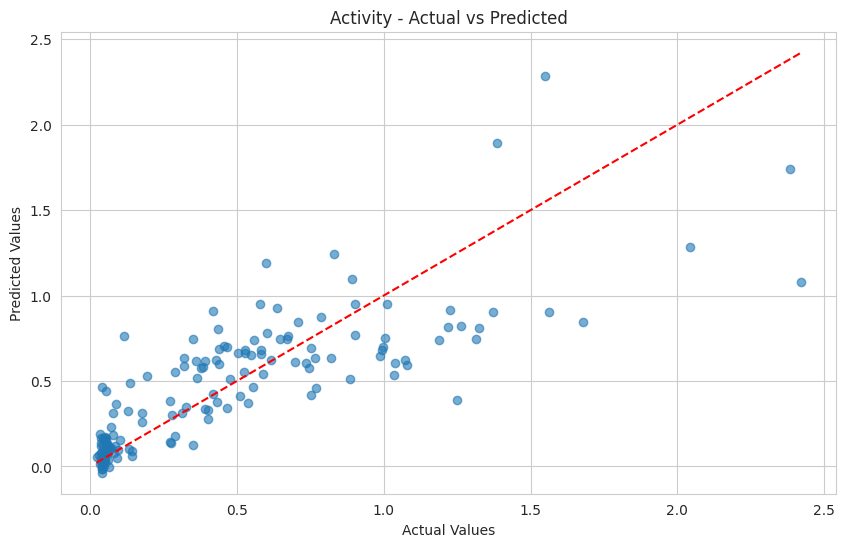

Selectivity - Mean Squared Error: 0.5606120800335486, Mean Absolute Error: 0.5602943955407612, R² Score: 0.4692755829203069
Selectivity - Spearman Correlation: 0.6961405605929344


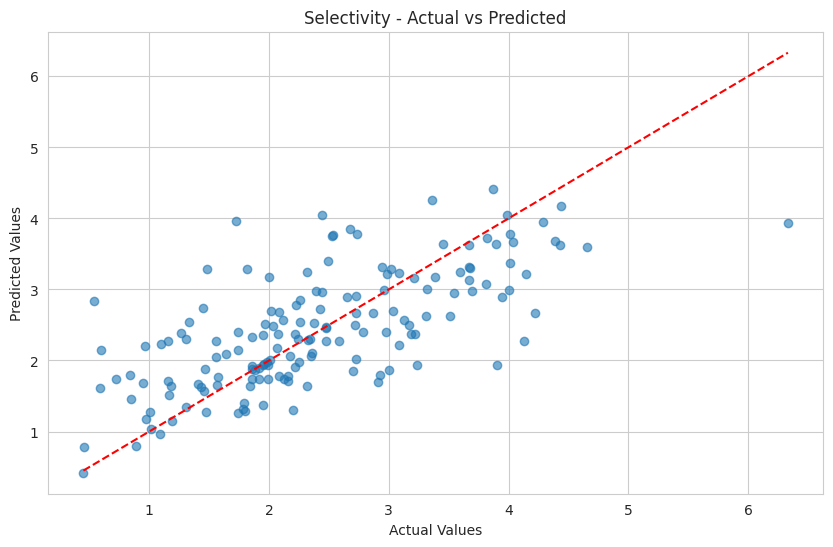

Label - Mean Squared Error: 0.8734980635639941, Mean Absolute Error: 0.5881522551112492, R² Score: 0.4381197272806635
Label - Spearman Correlation: 0.7760723075120122


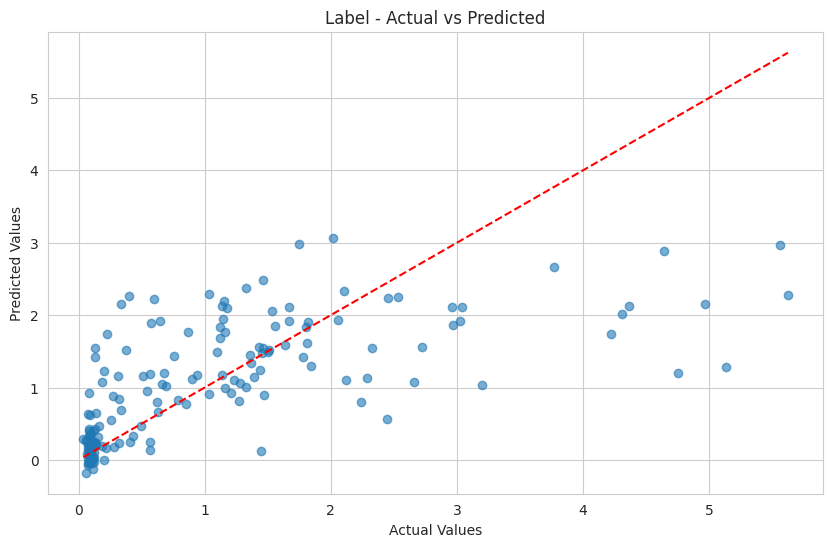

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def train_and_evaluate_model(X_train, X_test, y_train, y_test, target_name, trained_models):
    """Fit the model, make predictions, print metrics, and store the model."""
    
    # Define and fit the LGBM regressor
    lgbm_regressor = lgb.LGBMRegressor(random_state=42)
    lgbm_regressor.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = lgbm_regressor.predict(X_test)
    
    # Calculate and print the performance metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    spearman_corr, _ = spearmanr(y_test, y_pred)
    
    print(f'{target_name} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}, R² Score: {r2}')
    print(f'{target_name} - Spearman Correlation: {spearman_corr}')
    
    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') # Diagonal line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{target_name} - Actual vs Predicted')
    plt.grid(True)
    plt.show()
    
    # Storing the trained model
    trained_models[f'LGBM - {target_name}'] = lgbm_regressor
    
    return trained_models

# Assuming data is already split (X_train, X_test, etc.)
trained_models = {}  # Initializing the trained models dictionary

trained_models = train_and_evaluate_model(X_train, X_test, y_train_activity, y_test_activity, "Activity", trained_models)
trained_models = train_and_evaluate_model(X_train, X_test, y_train_selectivity, y_test_selectivity, "Selectivity", trained_models)
trained_models = train_and_evaluate_model(X_train, X_test, y_train_label, y_test_label, "Label", trained_models)


### HISTBOOSTINGRegressor来预测

Activity - Mean Squared Error: 0.07819444473291542, Mean Absolute Error: 0.18807169887895378, R^2: 0.6557848327749881
Activity - Spearman Correlation: 0.8651018757892515


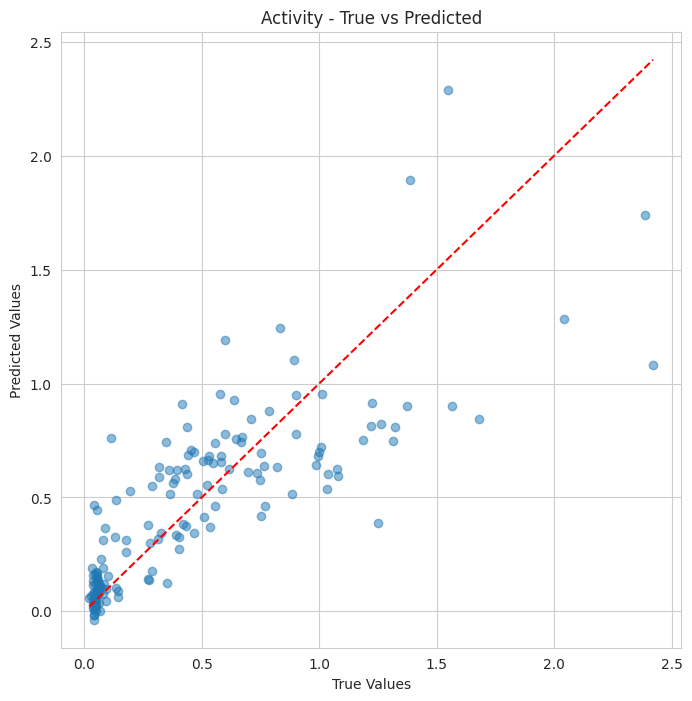

Selectivity - Mean Squared Error: 0.5617970215469903, Mean Absolute Error: 0.5608991426430752, R^2: 0.4681538136677478
Selectivity - Spearman Correlation: 0.6940574653066977


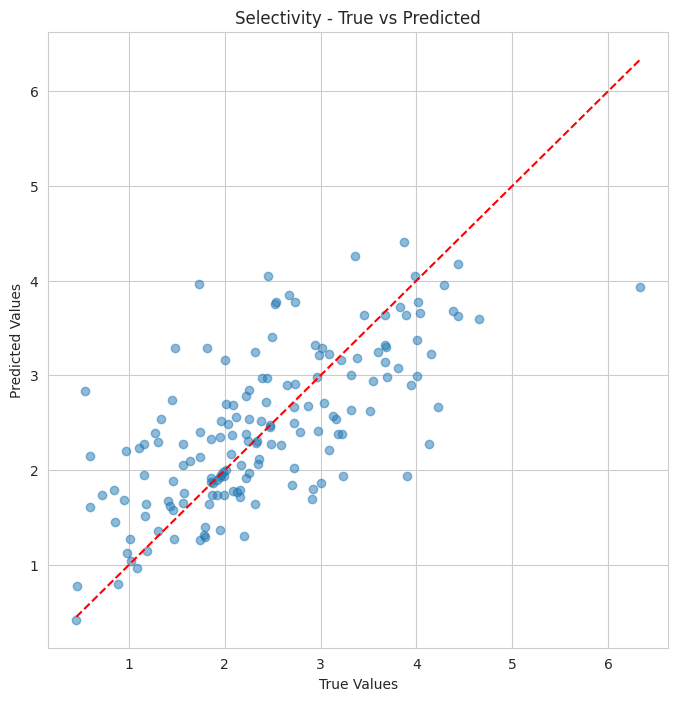

Label - Mean Squared Error: 0.8725877576714925, Mean Absolute Error: 0.5877214571536225, R^2: 0.43870528430073286
Label - Spearman Correlation: 0.7764795499824212


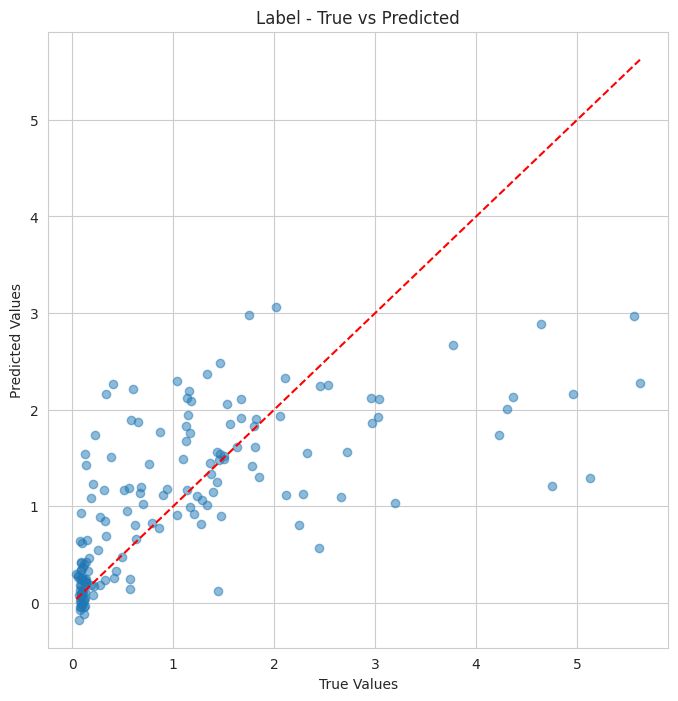

In [20]:
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import pandas as pd
import numpy as np

def train_and_evaluate_hist_gb(X_train, X_test, y_train, y_test, target_name, trained_models):
    """Train the HistGradientBoostingRegressor, predict, evaluate metrics, plot predictions, and store the model."""
    
    # Define and fit the regressor
    regressor = HistGradientBoostingRegressor(random_state=42)
    regressor.fit(X_train, y_train)
    
    # Predictions
    y_pred = regressor.predict(X_test)
    
    # Calculate and print performance metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    spearman_corr, _ = spearmanr(y_test, y_pred)
    
    print(f'{target_name} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}, R^2: {r2}')
    print(f'{target_name} - Spearman Correlation: {spearman_corr}')
    
    # Plotting
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # diagonal line
    plt.title(f'{target_name} - True vs Predicted')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()
    
    # Store the trained model
    trained_models[f'HistGradientBoosting - {target_name}'] = regressor
    
    return trained_models

# Assuming data is already split and trained_models is initialized
trained_models = {}  # Initializing the trained models dictionary

trained_models['HIST - Activity'] = train_and_evaluate_hist_gb(X_train, X_test, y_train_activity, y_test_activity, "Activity", trained_models)
trained_models['HIST - Selectivity'] = train_and_evaluate_hist_gb(X_train, X_test, y_train_selectivity, y_test_selectivity, "Selectivity", trained_models)
trained_models['HIST - label'] = train_and_evaluate_hist_gb(X_train, X_test, y_train_label, y_test_label, "Label", trained_models)


## adalead神经网络

In [21]:
!pip install flexs
!pip install viennarna
!pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 39.5 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 98.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [22]:
import pandas as pd
import numpy as np
from flexs.baselines.explorers.adalead import Adalead
from flexs.baselines import models
from sklearn.model_selection import train_test_split
import flexs
from flexs import baselines
from sklearn.metrics import r2_score

# 读取 Excel 表格并将其转换为 measured_sequences 数组
df = pd.read_excel('/kaggle/input/siatprotein2023/Rhla.xlsx') 
# measured_sequences 用于存储每个序列及其得分
df.head()


2023-10-25 17:00:36.513406: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 17:00:36.513528: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 17:00:36.513574: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


,Sequence,74,101,143,148,173,176,Normalized Activity,Normalized Selectivity,label
0,RAQLSQ,R,A,Q,L,S,Q,1.000000,1.000000,1.000000
1,AAQLSQ,A,A,Q,L,S,Q,3.228405,1.836564,5.929171
2,CAQLSQ,C,A,Q,L,S,Q,2.169509,2.445377,5.305268
3,DAQLSQ,D,A,Q,L,S,Q,1.758631,1.060698,1.865376
4,EAQLSQ,E,A,Q,L,S,Q,1.531251,1.031679,1.579759


In [23]:
measured_sequences = []
for i in range(len(df)):
    sequence = df.loc[i, 'Sequence'] # 读取序列
    score1 = df.loc[i, 'Normalized Activity'] # 读取活性
    score2 = df.loc[i, 'Normalized Selectivity'] # 读取选择性
    score3 = score1*score2 # 活性和选择性的乘积作为最终得分
    measured_sequences.append({'sequence': sequence, 'true_score': [score1*score2]}) 

# 将序列和得分分别提取到X和y中    
X = [seq['sequence'] for seq in measured_sequences]  
y = [seq['true_score'] for seq in measured_sequences]

# 将数据分割成训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# 将measured_sequences转换为DataFrame格式
measured_sequences_dict = {
    "sequence": [s['sequence'] for s in measured_sequences],  
    "true_score": [s['true_score'] for s in measured_sequences]
}
df1 = pd.DataFrame(measured_sequences_dict) 
df1['true_score'] = df1['true_score'].apply(lambda x: x[0]) 
df1.head()

,sequence,true_score
0,RAQLSQ,1.000000
1,AAQLSQ,5.929171
2,CAQLSQ,5.305268
3,DAQLSQ,1.865376
4,EAQLSQ,1.579759


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

alphabet="ACDEFGHIKLMNPQRSTVWY"
rf = baselines.models.RandomForest(alphabet=alphabet,random_state=42)#adalead自带的RF
rf.train(x_train, y_train)
rf_preds = rf.get_fitness(x_test)
mae = mean_absolute_error(y_test, rf_preds)
mse = mean_squared_error(y_test, rf_preds)
r2 = r2_score(y_test, rf_preds)
print("MAE:", mae)
print("MSE:", mse)
print("R-squared (R²):", r2)

adalead_instance = Adalead(
    rf,
    rounds=300,
    sequences_batch_size=200,
    model_queries_per_batch=1000,
    starting_sequence="",
    alphabet="ACDEFGHIKLMNPQRSTVWY",
    mu=1,
    recomb_rate=0.0,
    threshold=0.2,
    rho=0,
    eval_batch_size=30,
    log_file=None,
)

measured_sequences = []
for i in range(adalead_instance.rounds):
  sequences, scores = adalead_instance.propose_sequences(df1)
  for seq, score in zip(sequences, scores):
    if seq not in [s['sequence'] for s in measured_sequences]:
      measured_sequences.append({'sequence': seq, 'true_score': [score]})



/opt/conda/lib/python3.10/site-packages/flexs/baselines/models/sklearn_models.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model.fit(flattened, labels)


MAE: 0.5608008273836205
MSE: 0.9204638513487444
R-squared (R²): 0.3866602257493307


In [25]:
# 排序，取没有重复的前200个序列
measured_sequences.sort(key=lambda x: x['true_score'][0], reverse=True)
top200 = measured_sequences[:200]
for seq in top200:
  print(seq['sequence'])

LAQLKQ
LAQLKN
LAQLKR
LAQLKS
LAQLKP
LAQLKD
LAQLKL
LAVLKQ
LAQLKT
LAQLKY
LAQLKI
LAQLKG
LAQLKH
LAQLKC
LAQLKE
LAQLKF
LAQLKW
LAQLKV
LAYLSR
LARLKQ
LARLKM
LAVLKH
LAQLKM
LAYLSS
LAYLSL
LAYLSY
LAQLAQ
LAYLSP
LATLKQ
LAYLSD
LAYLSQ
LAYLSG
LAYLSI
LAYLSV
LAYLSH
LAYLST
LAYLSC
LAYLSE
LAYLSW
LARLSR
LAQLAR
LAYLSK
LARLSN
LAALKR
LATLKN
LALLKQ
LAALKQ
LACLKQ
LATLKD
LATLKG
LAHLKR
LATLKT
LAQLKA
LAQLKK
LAQLAN
LAYLSM
LAHLKQ
LATLKF
LATLKW
LAALKS
LAALKL
LAQLAK
LAHLKN
LAALKD
LAGLKR
LARLSY
LALLKL
LARLSD
LARLSS
LARLSQ
LARLSL
LARLSI
LARLSH
LARLSP
LARLSG
LARLST
LACLKP
LAWLKQ
LALLKP
LARLSE
LALLKG
LACLKH
LARLSW
LARLSC
LARLSF
LALLKE
LALLKC
LAELKQ
LAILKQ
LAMLKQ
LAKLKQ
LAGLKQ
LARLSV
LAYLSA
LARLSM
LARLSA
LAALKF
LAVLSN
LARLSK
LAKLKN
LADLKQ
LALLKV
LAVLSR
LAYLKQ
LAQLSK
LAQLAS
LAVLSK
LAQLAP
LAELKD
LAQLAD
LAVLSQ
LAQLAL
LAKLKY
LAKLKG
LAQLAT
LAILKH
LAGLKE
LAQLAY
LAQLAI
LAQLAG
LAQLAE
LAQLAH
LAQLAC
LAQLSR
LAFLKV
LAELKV
LADLKE
LAFLKQ
LAILKW
LAQLAV
LAVLSS
LAQLSA
LAQLAW
LASLKQ
LAPLKQ
LAVLSL
LAQLAA
LAVLSY
LAVLSA
LAQLSN
LAVLSP
LAVLSD
LAVLSG

## 预测测试集数据
处理测试集数据，生成对应csv文件

In [26]:
test_df = pd.read_csv("/kaggle/input/siatprotein2023/test.csv")
def encode_data(df, encoder, n_gram_encoders, amino_acid_dicts):
    """Encode data using specified encoders and generate features."""
    # Encode the sequences
    X_onehot = encoder.transform(df['Sequence'].apply(list).tolist())
    
    # Encode the n-grams
    n_gram_encodings = [n_gram_encoders[n].transform([generate_ngrams(seq, n) for seq in df['Sequence']])
                        for n in n_gram_encoders.keys()]
    
    # Generate basic features
    features_list = generate_features(df, amino_acid_dicts)
    
    # Combine all feature sets
    X_combined = pd.concat([pd.DataFrame(X_onehot)] + 
                           [pd.DataFrame(enc) for enc in n_gram_encodings] +
                           [pd.DataFrame(feature) for feature in features_list], axis=1)
    # Rename columns
    X_combined.columns = range(X_combined.shape[1])
    
    return X_combined

# Assuming training data (df) is loaded...
n_grams = [2, 3, 4]

# Fit the OneHotEncoder on the training data for amino acid sequences
encoder = OneHotEncoder(dtype=int, sparse=False, handle_unknown='ignore')
encoder.fit(df['Sequence'].apply(list).tolist())

# For n-grams, create and fit the encoders on the training data
n_gram_encoders = {}
for n in n_grams:
    n_gram_encoders[n] = OneHotEncoder(dtype=int, sparse=False, handle_unknown='ignore')
    n_gram_encoders[n].fit([generate_ngrams(seq, n) for seq in df['Sequence']])

# Preprocess the TEST data using already fitted encoders
X_combined_test = encode_data(test_df, encoder, n_gram_encoders, amino_acid_dicts)
print(X_combined_test)


     0     1     2     3     4     5     6     7     8     9     ...  4926  \
0       1     0     0     0     0     0     0     0     0     0  ...   0.0   
1       1     0     0     0     0     0     0     0     0     0  ...   0.0   
2       1     0     0     0     0     0     0     0     0     0  ...   0.0   
3       1     0     0     0     0     0     0     0     0     0  ...   0.0   
4       1     0     0     0     0     0     0     0     0     0  ...   0.0   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
920     0     0     0     0     0     0     0     0     0     0  ...   0.0   
921     0     0     0     0     0     0     0     0     0     0  ...   0.0   
922     0     0     0     0     0     0     0     0     0     0  ...   0.0   
923     0     0     0     0     0     0     0     0     0     0  ...   0.0   
924     0     0     0     0     0     0     0     0     0     0  ...   0.0   

         4927  4928  4929  4930      4931      4932      4933  

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

In [27]:
#这里更换预测模型要回去在运行一遍所选模型代码框
print(trained_models.keys())
# Use the trained models for predictions
result_df = pd.DataFrame()
result_df['SequenceID'] = test_df['SequenceID']

for label in ["Activity", "Selectivity"]:
    model_name = f'HistGradientBoosting - {label}'  # Use f-string to format the model name
    preds = trained_models[model_name].predict(X_combined_test)
    result_df[label] = preds

# Save the results to a CSV file
result_df.to_csv('HIST-predictions.csv', index=False)
print("Your submission was successfully saved!")

# View the results to ensure the format is correct before submission
print(result_df)


dict_keys(['HistGradientBoosting - Activity', 'HIST - Activity', 'HistGradientBoosting - Selectivity', 'HIST - Selectivity', 'HistGradientBoosting - Label', 'HIST - label'])
Your submission was successfully saved!
     SequenceID  Activity  Selectivity
0          1594  0.920806     3.118747
1          1595  1.147128     2.491589
2          1596  0.457925     2.536199
3          1597  1.033392     2.926850
4          1598  0.531114     3.782014
..          ...       ...          ...
920        2514  0.359320     3.395456
921        2515  0.189381     3.595716
922        2516  0.147793     2.906252
923        2517  0.287904     3.178063
924        2518  0.196718     2.997509

[925 rows x 3 columns]


# 3.生成序列：寻找最优96条序列
策略：集成算法+遍历突变空间，结合统计规律和训练测试集数据 找到可能最优的序列96条

## 生成所有突变空间

In [28]:
# import numpy as np
# import pandas as pd
# import itertools

# # 定义所有可能的氨基酸
# amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
# # 生成所有可能的组合
# combinations = [''.join(combo) for combo in itertools.product(amino_acids, repeat=6)]
# print(f"Generated {len(combinations)} combinations.")


## 预处理+分批预测
输出排名前400的序列，要运行比较久

In [29]:
# pip install tqdm

In [30]:
# print(trained_models.keys())

In [31]:
# from tqdm import tqdm

# def preprocess_and_predict_batch(comb_batch, encoder, n_gram_encoders, amino_acid_dicts, trained_models):
#     # Convert combinations to DataFrame
#     comb_df = pd.DataFrame({'Sequence': comb_batch})
    
#     # 使用之前定义的函数预处理组合
#     X_combinations_batch = encode_data(comb_df, encoder, n_gram_encoders, amino_acid_dicts)
    
#     # Make predictions for the batch
#     results = {
#         'Activity': trained_models['HistGradientBoosting - Activity'].predict(X_combinations_batch),
#         'Selectivity': trained_models['HistGradientBoosting - Selectivity'].predict(X_combinations_batch), 
#         'Label': trained_models['HistGradientBoosting - Label'].predict(X_combinations_batch)
#     }
#     results_df = pd.DataFrame(results)
#     results_df['Sequence'] = comb_batch
    
#     return results_df

# # Break into batches and process one batch at a time
# BATCH_SIZE = 50000  # Experiment with this number to see what your machine can handle
# n_batches = len(combinations) // BATCH_SIZE + 1
# predicted_results_list = []

# # Here we wrap the range with tqdm to create a progress bar
# for i in tqdm(range(n_batches), desc="Processing Batches"):
#     start_idx = i * BATCH_SIZE
#     end_idx = start_idx + BATCH_SIZE
#     comb_batch = combinations[start_idx:end_idx]
    
#     # Preprocess and predict for the batch and collect results
#     predicted_results_batch = preprocess_and_predict_batch(comb_batch, encoder, n_gram_encoders, amino_acid_dicts, trained_models)
#     predicted_results_list.append(predicted_results_batch)

# # Concatenate all batch results
# predicted_results = pd.concat(predicted_results_list, axis=0, ignore_index=True)
# print(predicted_results)


In [32]:
# # Concatenate all batch results
# predicted_results = pd.concat(predicted_results_list, axis=0, ignore_index=True)

# # Sort the predicted results by 'Activity', 'Selectivity', and 'Label' columns in descending order
# sorted_results = predicted_results.sort_values(by=['Activity', 'Selectivity', 'Label'], ascending=[False, False, False])

# # Select the top 400 sequences
# top_400_sequences = sorted_results['Sequence'].head(400)

# # Create a DataFrame for the top 400 sequences
# top_400_df = pd.DataFrame({'Sequence': top_400_sequences})

# # Save the top 400 sequences to a CSV file
# top_400_df.to_csv('top_400_sequences.csv', index=False)

# print("Top 400 sequences saved to 'top_400_sequences.csv'")


In [33]:
# # Sort the predicted results by 'Activity', 'Selectivity', and 'Label' columns in descending order
# sorted_results = predicted_results.sort_values(by=['Activity'], ascending=[False])

# # Select the top 400 sequences
# top_400_sequences = sorted_results['Sequence'].head(400)

# # Create a DataFrame for the top 400 sequences
# top_400_df = pd.DataFrame({'Sequence': top_400_sequences})

# # Save the top 400 sequences to a CSV file
# top_400_df.to_csv('top_400_sequences——act.csv', index=False)

# print("Top 400 sequences saved to 'top_400_sequences-act.csv'")
# print(top_400_df)